In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import tensorflow_addons as tfa

In [2]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
data_path = '/home/shellygoel2324/data_merged.csv'
#labels_path = '/home/shellygoel2324/processedLabels.csv'

In [22]:
def load_pose_landmarks(csv_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    
    dataframe["label"] = dataframe["label"] - 1
  
    print(dataframe["label"].unique())
    
    
    curr_num = dataframe.loc[dataframe['label'] == 0]
    
    dataFinal = curr_num.sample(n=5000)
    #print(f"{i}:{curr_num_sub.shape}")
    #dataFinal.append(curr_num_sub)
    
    print(f"{0}:{dataFinal.shape}")
    
    '''
    0: 5000
    1:2500*2
        2: 1000*5
            3:250*20
                4: 250*20
                    5: 50*100
                
    '''
        
    for i in range(1, 6):
        
        curr_num = dataframe.loc[dataframe['label'] == i]
        
        '''
        num_s = 0
        if i == 1:
            num_s = 2
        if i == 2:
            num_s = 5
        if i == 3:
            num_s = 20
        if i == 4:
            num_s = 20     
        if i == 5:
            num_s = 100
            '''
            
        curr_num_sub = curr_num.sample(n=5000, replace = True)
        print(f"{i}:{curr_num_sub.shape}")
        dataFinal = dataFinal.append(curr_num_sub, ignore_index=True)
        
    
    
    print(dataFinal.shape)
    
    dataframe = dataFinal
    labels = dataframe["label"]#pd.read_csv(labels_path, header=None)
    
    print(labels.unique())
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')
    df_to_process.pop('label')

    # Extract the labels
    y = labels
    classes = range(6)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

In [23]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path)

print(X.shape, y.shape)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

#print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

[0. 3. 1. 2. 4. 5.]
0:(5000, 55)
1:(5000, 55)
2:(5000, 55)
3:(5000, 55)
4:(5000, 55)
5:(5000, 55)
(30000, 55)
[0. 1. 2. 3. 4. 5.]
(30000, 51) (30000, 6)


In [24]:
print("TRAIN DISTRIBUTION")

sample_dist = []
for i in range(0,6):
    
    num_i = 0
    for sample in y_train:
            if tf.argmax(sample) == i:
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    print(f"{i}: {num_i}")
    sample_dist.append(dist)


print("\nTEST DISTRIBUTION")
for i in range(0,6):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")
    #sample_dist.append(dist)

TRAIN DISTRIBUTION
0: 0.16495833333333335
0: 3959
1: 0.16629166666666667
1: 3991
2: 0.1675
2: 4020
3: 0.16695833333333332
3: 4007
4: 0.167125
4: 4011
5: 0.16716666666666666
5: 4012

TEST DISTRIBUTION
0: 0.17333333333333334
1: 0.168
2: 0.165
3: 0.159
4: 0.16533333333333333
5: 0.16933333333333334


In [25]:
sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

print(sample_dist)
print(weight_balanced)
#weight_balanced = weight_balanced/np.linalg.norm(weight_balanced)
#print(weight_balanced)
#print(np.sum(weight_balanced))

[0.40405853 0.40732448 0.41028424 0.40895745 0.40936569 0.40946775]
[2.474888942451101, 2.455045182451493, 2.43733465750346, 2.445242157016199, 2.4428036208336845, 2.442194746551323]


In [26]:
class_weights = {}
for i in range(6):
    class_weights[i] = weight_balanced[i]

In [27]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    landmarks = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Normalize everything

In [29]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 17, 3)        0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 17, 2)       0           ['reshape[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 2)           0           ['tf.__operators__.getitem[0]

 )                                                                                                
                                                                                                  
 tf.broadcast_to_1 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_1[0][0]',       
                                                                  'tf.compat.v1.floor_div_1[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 2)           0           ['tf.math.multiply_4[0][0]',     
 mbda)                                                            'tf.math.multiply_5[0][0]']     
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 2)           0           ['tf.math.multiply_2[0][0]',     
 mbda)    

In [30]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [31]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),#'categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.best.onlyfocalloss"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
1481/1500 [============================>.] - ETA: 0s - loss: 0.1870 - tp: 4824.0000 - fp: 720.0000 - tn: 117760.0000 - fn: 18872.0000 - accuracy: 0.8622 - precision: 0.8701 - recall: 0.2036 - auc: 0.8936 - prc: 0.6644
Epoch 1: val_loss improved from inf to 0.12727, saving model to weights.best.onlyfocalloss


2022-05-31 04:35:43.563650: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1500/1500 [==============================] - 9s 5ms/step - loss: 0.1866 - tp: 4930.0000 - fp: 733.0000 - tn: 119267.0000 - fn: 19070.0000 - accuracy: 0.8625 - precision: 0.8706 - recall: 0.2054 - auc: 0.8940 - prc: 0.6657 - val_loss: 0.1273 - val_tp: 1250.0000 - val_fp: 109.0000 - val_tn: 14891.0000 - val_fn: 1750.0000 - val_accuracy: 0.8967 - val_precision: 0.9198 - val_recall: 0.4167 - val_auc: 0.9543 - val_prc: 0.8291
Epoch 2/200
1481/1500 [============================>.] - ETA: 0s - loss: 0.1378 - tp: 9118.0000 - fp: 1086.0000 - tn: 117394.0000 - fn: 14578.0000 - accuracy: 0.8898 - precision: 0.8936 - recall: 0.3848 - auc: 0.9450 - prc: 0.7965
Epoch 2: val_loss improved from 0.12727 to 0.10641, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1378 - tp: 9247.0000 - fp: 1105.0000 - tn: 1

INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0980 - tp: 14680.0000 - fp: 1289.0000 - tn: 118711.0000 - fn: 9320.0000 - accuracy: 0.9263 - precision: 0.9193 - recall: 0.6117 - auc: 0.9732 - prc: 0.8932 - val_loss: 0.0788 - val_tp: 2039.0000 - val_fp: 133.0000 - val_tn: 14867.0000 - val_fn: 961.0000 - val_accuracy: 0.9392 - val_precision: 0.9388 - val_recall: 0.6797 - val_auc: 0.9832 - val_prc: 0.9298
Epoch 12/200
1493/1500 [============================>.] - ETA: 0s - loss: 0.0964 - tp: 14759.0000 - fp: 1281.0000 - tn: 118159.0000 - fn: 9129.0000 - accuracy: 0.9274 - precision: 0.9201 - recall: 0.6178 - auc: 0.9740 - prc: 0.8965
Epoch 12: val_loss did not improve from 0.07884
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0964 - tp: 14831.0000 - fp: 1285.0000 - tn: 118715.0000 - fn: 9169.0000 - accuracy: 0.9274 - precision: 0.9203 - recall: 0.6180 - auc: 0.9740 - prc: 0.8965 - v

1480/1500 [============================>.] - ETA: 0s - loss: 0.0886 - tp: 15540.0000 - fp: 1209.0000 - tn: 117191.0000 - fn: 8140.0000 - accuracy: 0.9342 - precision: 0.9278 - recall: 0.6562 - auc: 0.9783 - prc: 0.9127
Epoch 22: val_loss did not improve from 0.07151
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0885 - tp: 15764.0000 - fp: 1225.0000 - tn: 118775.0000 - fn: 8236.0000 - accuracy: 0.9343 - precision: 0.9279 - recall: 0.6568 - auc: 0.9784 - prc: 0.9128 - val_loss: 0.0718 - val_tp: 2103.0000 - val_fp: 111.0000 - val_tn: 14889.0000 - val_fn: 897.0000 - val_accuracy: 0.9440 - val_precision: 0.9499 - val_recall: 0.7010 - val_auc: 0.9863 - val_prc: 0.9414
Epoch 23/200
1499/1500 [============================>.] - ETA: 0s - loss: 0.0890 - tp: 15785.0000 - fp: 1215.0000 - tn: 118705.0000 - fn: 8199.0000 - accuracy: 0.9346 - precision: 0.9285 - recall: 0.6581 - auc: 0.9781 - prc: 0.9125
Epoch 23: val_loss improved from 0.07151 to 0.06992, saving model to weights

Epoch 33/200
1487/1500 [============================>.] - ETA: 0s - loss: 0.0840 - tp: 16135.0000 - fp: 1227.0000 - tn: 117733.0000 - fn: 7657.0000 - accuracy: 0.9378 - precision: 0.9293 - recall: 0.6782 - auc: 0.9806 - prc: 0.9221
Epoch 33: val_loss improved from 0.06767 to 0.06512, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0842 - tp: 16278.0000 - fp: 1237.0000 - tn: 118763.0000 - fn: 7722.0000 - accuracy: 0.9378 - precision: 0.9294 - recall: 0.6783 - auc: 0.9805 - prc: 0.9219 - val_loss: 0.0651 - val_tp: 2183.0000 - val_fp: 100.0000 - val_tn: 14900.0000 - val_fn: 817.0000 - val_accuracy: 0.9491 - val_precision: 0.9562 - val_recall: 0.7277 - val_auc: 0.9888 - val_prc: 0.9528
Epoch 34/200
1499/1500 [============================>.] - ETA: 0s - loss: 0.0843 - tp: 16301.0000 - fp: 1184.0000 - tn: 118736.0000 - fn: 7683.0000 - accuracy: 0.9384 - precision

Epoch 44/200
1496/1500 [============================>.] - ETA: 0s - loss: 0.0818 - tp: 16509.0000 - fp: 1141.0000 - tn: 118539.0000 - fn: 7427.0000 - accuracy: 0.9403 - precision: 0.9354 - recall: 0.6897 - auc: 0.9819 - prc: 0.9261
Epoch 44: val_loss improved from 0.06261 to 0.06162, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0817 - tp: 16557.0000 - fp: 1144.0000 - tn: 118856.0000 - fn: 7443.0000 - accuracy: 0.9404 - precision: 0.9354 - recall: 0.6899 - auc: 0.9819 - prc: 0.9262 - val_loss: 0.0616 - val_tp: 2212.0000 - val_fp: 90.0000 - val_tn: 14910.0000 - val_fn: 788.0000 - val_accuracy: 0.9512 - val_precision: 0.9609 - val_recall: 0.7373 - val_auc: 0.9900 - val_prc: 0.9580
Epoch 45/200
1499/1500 [============================>.] - ETA: 0s - loss: 0.0820 - tp: 16601.0000 - fp: 1160.0000 - tn: 118760.0000 - fn: 7383.0000 - accuracy: 0.9406 - precision:

Epoch 55/200
1494/1500 [============================>.] - ETA: 0s - loss: 0.0795 - tp: 16816.0000 - fp: 1154.0000 - tn: 118366.0000 - fn: 7088.0000 - accuracy: 0.9425 - precision: 0.9358 - recall: 0.7035 - auc: 0.9829 - prc: 0.9307
Epoch 55: val_loss improved from 0.06008 to 0.05959, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0795 - tp: 16879.0000 - fp: 1157.0000 - tn: 118843.0000 - fn: 7121.0000 - accuracy: 0.9425 - precision: 0.9359 - recall: 0.7033 - auc: 0.9829 - prc: 0.9307 - val_loss: 0.0596 - val_tp: 2262.0000 - val_fp: 78.0000 - val_tn: 14922.0000 - val_fn: 738.0000 - val_accuracy: 0.9547 - val_precision: 0.9667 - val_recall: 0.7540 - val_auc: 0.9906 - val_prc: 0.9607
Epoch 56/200
1497/1500 [============================>.] - ETA: 0s - loss: 0.0786 - tp: 16953.0000 - fp: 1141.0000 - tn: 118619.0000 - fn: 6999.0000 - accuracy: 0.9434 - precision

Epoch 66/200
1497/1500 [============================>.] - ETA: 0s - loss: 0.0787 - tp: 16897.0000 - fp: 1104.0000 - tn: 118656.0000 - fn: 7055.0000 - accuracy: 0.9432 - precision: 0.9387 - recall: 0.7055 - auc: 0.9833 - prc: 0.9322
Epoch 66: val_loss did not improve from 0.05804
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0787 - tp: 16926.0000 - fp: 1106.0000 - tn: 118894.0000 - fn: 7074.0000 - accuracy: 0.9432 - precision: 0.9387 - recall: 0.7053 - auc: 0.9833 - prc: 0.9321 - val_loss: 0.0586 - val_tp: 2311.0000 - val_fp: 92.0000 - val_tn: 14908.0000 - val_fn: 689.0000 - val_accuracy: 0.9566 - val_precision: 0.9617 - val_recall: 0.7703 - val_auc: 0.9909 - val_prc: 0.9616
Epoch 67/200
1500/1500 [==============================] - ETA: 0s - loss: 0.0777 - tp: 17079.0000 - fp: 1136.0000 - tn: 118864.0000 - fn: 6921.0000 - accuracy: 0.9440 - precision: 0.9376 - recall: 0.7116 - auc: 0.9837 - prc: 0.9341
Epoch 67: val_loss did not improve from 0.05804
1500/1500 [=====

1500/1500 [==============================] - ETA: 0s - loss: 0.0747 - tp: 17423.0000 - fp: 1137.0000 - tn: 118863.0000 - fn: 6577.0000 - accuracy: 0.9464 - precision: 0.9387 - recall: 0.7260 - auc: 0.9850 - prc: 0.9384
Epoch 77: val_loss did not improve from 0.05688
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0747 - tp: 17423.0000 - fp: 1137.0000 - tn: 118863.0000 - fn: 6577.0000 - accuracy: 0.9464 - precision: 0.9387 - recall: 0.7260 - auc: 0.9850 - prc: 0.9384 - val_loss: 0.0570 - val_tp: 2337.0000 - val_fp: 97.0000 - val_tn: 14903.0000 - val_fn: 663.0000 - val_accuracy: 0.9578 - val_precision: 0.9601 - val_recall: 0.7790 - val_auc: 0.9912 - val_prc: 0.9635
Epoch 78/200
1496/1500 [============================>.] - ETA: 0s - loss: 0.0771 - tp: 17248.0000 - fp: 1110.0000 - tn: 118570.0000 - fn: 6688.0000 - accuracy: 0.9457 - precision: 0.9395 - recall: 0.7206 - auc: 0.9839 - prc: 0.9356
Epoch 78: val_loss did not improve from 0.05688
1500/1500 [==================

Epoch 88/200
1489/1500 [============================>.] - ETA: 0s - loss: 0.0757 - tp: 17302.0000 - fp: 1100.0000 - tn: 118020.0000 - fn: 6522.0000 - accuracy: 0.9467 - precision: 0.9402 - recall: 0.7262 - auc: 0.9844 - prc: 0.9372
Epoch 88: val_loss did not improve from 0.05503
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0758 - tp: 17423.0000 - fp: 1108.0000 - tn: 118892.0000 - fn: 6577.0000 - accuracy: 0.9466 - precision: 0.9402 - recall: 0.7260 - auc: 0.9843 - prc: 0.9371 - val_loss: 0.0575 - val_tp: 2362.0000 - val_fp: 114.0000 - val_tn: 14886.0000 - val_fn: 638.0000 - val_accuracy: 0.9582 - val_precision: 0.9540 - val_recall: 0.7873 - val_auc: 0.9911 - val_prc: 0.9628
Epoch 89/200
1484/1500 [============================>.] - ETA: 0s - loss: 0.0754 - tp: 17184.0000 - fp: 1094.0000 - tn: 117626.0000 - fn: 6560.0000 - accuracy: 0.9463 - precision: 0.9401 - recall: 0.7237 - auc: 0.9844 - prc: 0.9375
Epoch 89: val_loss did not improve from 0.05503
1500/1500 [====

1489/1500 [============================>.] - ETA: 0s - loss: 0.0737 - tp: 17512.0000 - fp: 1127.0000 - tn: 117993.0000 - fn: 6312.0000 - accuracy: 0.9480 - precision: 0.9395 - recall: 0.7351 - auc: 0.9854 - prc: 0.9410
Epoch 99: val_loss did not improve from 0.05402
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0736 - tp: 17647.0000 - fp: 1134.0000 - tn: 118866.0000 - fn: 6353.0000 - accuracy: 0.9480 - precision: 0.9396 - recall: 0.7353 - auc: 0.9855 - prc: 0.9411 - val_loss: 0.0559 - val_tp: 2365.0000 - val_fp: 94.0000 - val_tn: 14906.0000 - val_fn: 635.0000 - val_accuracy: 0.9595 - val_precision: 0.9618 - val_recall: 0.7883 - val_auc: 0.9917 - val_prc: 0.9649
Epoch 100/200
1495/1500 [============================>.] - ETA: 0s - loss: 0.0739 - tp: 17450.0000 - fp: 1107.0000 - tn: 118493.0000 - fn: 6470.0000 - accuracy: 0.9472 - precision: 0.9403 - recall: 0.7295 - auc: 0.9852 - prc: 0.9402
Epoch 100: val_loss did not improve from 0.05402
1500/1500 [================

1489/1500 [============================>.] - ETA: 0s - loss: 0.0743 - tp: 17316.0000 - fp: 1084.0000 - tn: 118036.0000 - fn: 6508.0000 - accuracy: 0.9469 - precision: 0.9411 - recall: 0.7268 - auc: 0.9852 - prc: 0.9393
Epoch 110: val_loss did not improve from 0.05256
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0742 - tp: 17452.0000 - fp: 1094.0000 - tn: 118906.0000 - fn: 6548.0000 - accuracy: 0.9469 - precision: 0.9410 - recall: 0.7272 - auc: 0.9852 - prc: 0.9394 - val_loss: 0.0543 - val_tp: 2388.0000 - val_fp: 106.0000 - val_tn: 14894.0000 - val_fn: 612.0000 - val_accuracy: 0.9601 - val_precision: 0.9575 - val_recall: 0.7960 - val_auc: 0.9923 - val_prc: 0.9666
Epoch 111/200
1496/1500 [============================>.] - ETA: 0s - loss: 0.0744 - tp: 17561.0000 - fp: 1046.0000 - tn: 118634.0000 - fn: 6375.0000 - accuracy: 0.9483 - precision: 0.9438 - recall: 0.7337 - auc: 0.9852 - prc: 0.9399
Epoch 111: val_loss did not improve from 0.05256
1500/1500 [==============

Epoch 122/200
1489/1500 [============================>.] - ETA: 0s - loss: 0.0715 - tp: 17684.0000 - fp: 1104.0000 - tn: 118016.0000 - fn: 6140.0000 - accuracy: 0.9493 - precision: 0.9412 - recall: 0.7423 - auc: 0.9862 - prc: 0.9440
Epoch 122: val_loss did not improve from 0.05256
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0715 - tp: 17818.0000 - fp: 1110.0000 - tn: 118890.0000 - fn: 6182.0000 - accuracy: 0.9494 - precision: 0.9414 - recall: 0.7424 - auc: 0.9863 - prc: 0.9440 - val_loss: 0.0535 - val_tp: 2391.0000 - val_fp: 95.0000 - val_tn: 14905.0000 - val_fn: 609.0000 - val_accuracy: 0.9609 - val_precision: 0.9618 - val_recall: 0.7970 - val_auc: 0.9924 - val_prc: 0.9677
Epoch 123/200
1491/1500 [============================>.] - ETA: 0s - loss: 0.0722 - tp: 17591.0000 - fp: 1109.0000 - tn: 118171.0000 - fn: 6265.0000 - accuracy: 0.9485 - precision: 0.9407 - recall: 0.7374 - auc: 0.9860 - prc: 0.9427
Epoch 123: val_loss did not improve from 0.05256
1500/1500 [=

1494/1500 [============================>.] - ETA: 0s - loss: 0.0701 - tp: 17918.0000 - fp: 1104.0000 - tn: 118416.0000 - fn: 5986.0000 - accuracy: 0.9506 - precision: 0.9420 - recall: 0.7496 - auc: 0.9867 - prc: 0.9458
Epoch 133: val_loss did not improve from 0.05203
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0700 - tp: 17994.0000 - fp: 1107.0000 - tn: 118893.0000 - fn: 6006.0000 - accuracy: 0.9506 - precision: 0.9420 - recall: 0.7498 - auc: 0.9867 - prc: 0.9458 - val_loss: 0.0539 - val_tp: 2331.0000 - val_fp: 80.0000 - val_tn: 14920.0000 - val_fn: 669.0000 - val_accuracy: 0.9584 - val_precision: 0.9668 - val_recall: 0.7770 - val_auc: 0.9924 - val_prc: 0.9679
Epoch 134/200
1498/1500 [============================>.] - ETA: 0s - loss: 0.0714 - tp: 17831.0000 - fp: 1074.0000 - tn: 118766.0000 - fn: 6137.0000 - accuracy: 0.9499 - precision: 0.9432 - recall: 0.7440 - auc: 0.9862 - prc: 0.9443
Epoch 134: val_loss did not improve from 0.05203
1500/1500 [===============

1497/1500 [============================>.] - ETA: 0s - loss: 0.0704 - tp: 17862.0000 - fp: 1053.0000 - tn: 118707.0000 - fn: 6090.0000 - accuracy: 0.9503 - precision: 0.9443 - recall: 0.7457 - auc: 0.9867 - prc: 0.9457
Epoch 144: val_loss did not improve from 0.05087
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0704 - tp: 17897.0000 - fp: 1055.0000 - tn: 118945.0000 - fn: 6103.0000 - accuracy: 0.9503 - precision: 0.9443 - recall: 0.7457 - auc: 0.9867 - prc: 0.9456 - val_loss: 0.0520 - val_tp: 2450.0000 - val_fp: 105.0000 - val_tn: 14895.0000 - val_fn: 550.0000 - val_accuracy: 0.9636 - val_precision: 0.9589 - val_recall: 0.8167 - val_auc: 0.9928 - val_prc: 0.9694
Epoch 145/200
1493/1500 [============================>.] - ETA: 0s - loss: 0.0701 - tp: 17840.0000 - fp: 1092.0000 - tn: 118348.0000 - fn: 6048.0000 - accuracy: 0.9502 - precision: 0.9423 - recall: 0.7468 - auc: 0.9867 - prc: 0.9461
Epoch 145: val_loss improved from 0.05087 to 0.05069, saving model to weig

1487/1500 [============================>.] - ETA: 0s - loss: 0.0699 - tp: 17844.0000 - fp: 1082.0000 - tn: 117878.0000 - fn: 5948.0000 - accuracy: 0.9508 - precision: 0.9428 - recall: 0.7500 - auc: 0.9870 - prc: 0.9466
Epoch 155: val_loss did not improve from 0.05038
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0699 - tp: 17999.0000 - fp: 1089.0000 - tn: 118911.0000 - fn: 6001.0000 - accuracy: 0.9508 - precision: 0.9429 - recall: 0.7500 - auc: 0.9870 - prc: 0.9466 - val_loss: 0.0518 - val_tp: 2476.0000 - val_fp: 133.0000 - val_tn: 14867.0000 - val_fn: 524.0000 - val_accuracy: 0.9635 - val_precision: 0.9490 - val_recall: 0.8253 - val_auc: 0.9929 - val_prc: 0.9699
Epoch 156/200
1490/1500 [============================>.] - ETA: 0s - loss: 0.0692 - tp: 18022.0000 - fp: 1102.0000 - tn: 118098.0000 - fn: 5818.0000 - accuracy: 0.9516 - precision: 0.9424 - recall: 0.7560 - auc: 0.9871 - prc: 0.9475
Epoch 156: val_loss did not improve from 0.05038
1500/1500 [==============

Epoch 167/200
1494/1500 [============================>.] - ETA: 0s - loss: 0.0692 - tp: 18066.0000 - fp: 1085.0000 - tn: 118435.0000 - fn: 5838.0000 - accuracy: 0.9517 - precision: 0.9433 - recall: 0.7558 - auc: 0.9872 - prc: 0.9474
Epoch 167: val_loss did not improve from 0.04958
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0692 - tp: 18142.0000 - fp: 1089.0000 - tn: 118911.0000 - fn: 5858.0000 - accuracy: 0.9518 - precision: 0.9434 - recall: 0.7559 - auc: 0.9872 - prc: 0.9475 - val_loss: 0.0507 - val_tp: 2478.0000 - val_fp: 97.0000 - val_tn: 14903.0000 - val_fn: 522.0000 - val_accuracy: 0.9656 - val_precision: 0.9623 - val_recall: 0.8260 - val_auc: 0.9933 - val_prc: 0.9714
Epoch 168/200
1493/1500 [============================>.] - ETA: 0s - loss: 0.0693 - tp: 17937.0000 - fp: 1064.0000 - tn: 118376.0000 - fn: 5951.0000 - accuracy: 0.9511 - precision: 0.9440 - recall: 0.7509 - auc: 0.9870 - prc: 0.9473
Epoch 168: val_loss did not improve from 0.04958
1500/1500 [=

Epoch 179/200
1483/1500 [============================>.] - ETA: 0s - loss: 0.0684 - tp: 18091.0000 - fp: 1068.0000 - tn: 117572.0000 - fn: 5637.0000 - accuracy: 0.9529 - precision: 0.9443 - recall: 0.7624 - auc: 0.9875 - prc: 0.9491
Epoch 179: val_loss did not improve from 0.04958
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0684 - tp: 18295.0000 - fp: 1085.0000 - tn: 118915.0000 - fn: 5705.0000 - accuracy: 0.9528 - precision: 0.9440 - recall: 0.7623 - auc: 0.9875 - prc: 0.9491 - val_loss: 0.0511 - val_tp: 2415.0000 - val_fp: 89.0000 - val_tn: 14911.0000 - val_fn: 585.0000 - val_accuracy: 0.9626 - val_precision: 0.9645 - val_recall: 0.8050 - val_auc: 0.9931 - val_prc: 0.9705
Epoch 180/200
1499/1500 [============================>.] - ETA: 0s - loss: 0.0682 - tp: 18152.0000 - fp: 1054.0000 - tn: 118866.0000 - fn: 5832.0000 - accuracy: 0.9521 - precision: 0.9451 - recall: 0.7568 - auc: 0.9874 - prc: 0.9488
Epoch 180: val_loss improved from 0.04958 to 0.04895, saving 

Epoch 191/200
1498/1500 [============================>.] - ETA: 0s - loss: 0.0684 - tp: 18253.0000 - fp: 1087.0000 - tn: 118753.0000 - fn: 5715.0000 - accuracy: 0.9527 - precision: 0.9438 - recall: 0.7616 - auc: 0.9876 - prc: 0.9490
Epoch 191: val_loss did not improve from 0.04895
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0684 - tp: 18277.0000 - fp: 1088.0000 - tn: 118912.0000 - fn: 5723.0000 - accuracy: 0.9527 - precision: 0.9438 - recall: 0.7615 - auc: 0.9876 - prc: 0.9490 - val_loss: 0.0509 - val_tp: 2438.0000 - val_fp: 101.0000 - val_tn: 14899.0000 - val_fn: 562.0000 - val_accuracy: 0.9632 - val_precision: 0.9602 - val_recall: 0.8127 - val_auc: 0.9932 - val_prc: 0.9709
Epoch 192/200
1492/1500 [============================>.] - ETA: 0s - loss: 0.0679 - tp: 18181.0000 - fp: 1025.0000 - tn: 118335.0000 - fn: 5691.0000 - accuracy: 0.9531 - precision: 0.9466 - recall: 0.7616 - auc: 0.9877 - prc: 0.9498
Epoch 192: val_loss improved from 0.04895 to 0.04768, saving

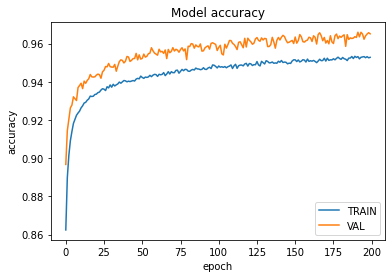

In [32]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

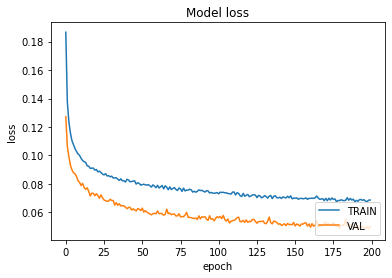

In [33]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [34]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

94/94 [==============================] - 0s 4ms/step - loss: 0.0798 - tp: 2062.0000 - fp: 95.0000 - tn: 14905.0000 - fn: 938.0000 - accuracy: 0.9426 - precision: 0.9560 - recall: 0.6873 - auc: 0.9813 - prc: 0.9300


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.80      0.88       520
           1       0.78      0.84      0.80       504
           2       0.84      0.86      0.85       495
           3       0.81      0.68      0.74       477
           4       0.81      0.94      0.87       496
           5       0.92      1.00      0.96       508

    accuracy                           0.85      3000
   macro avg       0.86      0.85      0.85      3000
weighted avg       0.86      0.85      0.85      3000



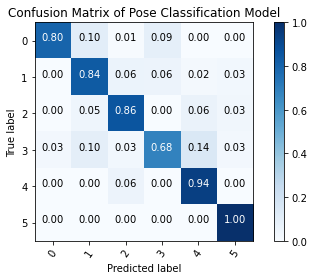

In [35]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [ ]:
#Classes 3, 4 Need to be weighted

